### 2022-1 Artificial Intelligence (01)
## Live Session #3-1: ResNet-18 with Keras Layers
---
Copyright (c) Prof. Jaehyeong Sim 

Department of Computer Science and Engineering

Ewha Womans University

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

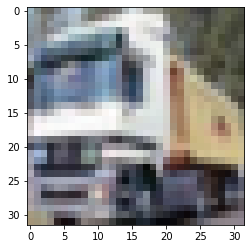

In [3]:
plt.imshow(X_train[1])

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [7]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [8]:
class IdentityBlock(tf.keras.Model):
  def __init__(self, filters, downsample=False):
    super(IdentityBlock, self).__init__(name='')

    self.conv1 = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.act1 = tf.keras.layers.Activation('relu')

    self.conv2 = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.act2 = tf.keras.layers.Activation('relu')

    self.add = tf.keras.layers.Add()

    self.downsample = downsample
    # 다운샘플이 트루인 경우
    if self.downsample:
      self.ds = tf.keras.layers.Conv2D(filters, strides=2, kernel_size=(1,1), padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
      self.dsbn = tf.keras.layers.BatchNormalization()

  def call(self, inputs):
    ds = inputs
    if self.downsample:
      ds = self.ds(inputs)
      ds = self.dsbn(ds)

    x = self.conv1(ds)
    x = self.bn1(x)
    x = self.act1(x)
    
    x = self.conv2(x)
    x = self.bn2(x)

    x = self.add([x, ds])
    out = self.act2(x)

    return out

In [9]:
class ResNet18(tf.keras.Model):
  def __init__(self, num_classes):
    super(ResNet18, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(64, strides=2, kernel_size=(7,7), padding='same', kernel_regularizer = tf.keras.regularizers.l2(0.0005))
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.act1 = tf.keras.layers.Activation('relu')
    self.maxp = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2)

    self.conv2x1 = IdentityBlock(64, downsample=False)
    self.conv2x2 = IdentityBlock(64, downsample=False)

    self.conv3x1 = IdentityBlock(128, downsample=True)
    self.conv3x2 = IdentityBlock(128, downsample=False)

    self.conv4x1 = IdentityBlock(256, downsample=True)
    self.conv4x2 = IdentityBlock(256, downsample=False)

    self.conv5x1 = IdentityBlock(512, downsample=True)
    self.conv5x2 = IdentityBlock(512, downsample=False)

    self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.flat = tf.keras.layers.Flatten()
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.act1(x)
    x = self.maxp(x)

    for idblock in [self.conv2x1, self.conv2x2, self.conv3x1, self.conv3x2, \
                    self.conv4x1, self.conv4x2, self.conv5x1, self.conv5x2]:
      x = idblock(x)

    x = self.avg_pool(x)
    x = self.flat(x)
    x = self.dropout(x)
    out = self.fc(x)

    return out

In [10]:
model = ResNet18(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(aug.flow(X_train,Y_train,batch_size = 256), batch_size=256, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
704/704 [==============================] - 62s 75ms/step - loss: 2.9534 - accuracy: 0.4054 - val_loss: 2.5027 - val_accuracy: 0.4476
Epoch 2/10
704/704 [==============================] - 48s 68ms/step - loss: 2.1171 - accuracy: 0.5276 - val_loss: 2.1452 - val_accuracy: 0.4390
Epoch 3/10
704/704 [==============================] - 47s 67ms/step - loss: 1.7615 - accuracy: 0.5848 - val_loss: 1.8872 - val_accuracy: 0.5350
Epoch 4/10
704/704 [==============================] - 47s 66ms/step - loss: 1.5114 - accuracy: 0.6227 - val_loss: 1.7048 - val_accuracy: 0.5770
Epoch 5/10
704/704 [==============================] - 46s 66ms/step - loss: 1.3777 - accuracy: 0.6476 - val_loss: 1.6158 - val_accuracy: 0.5588
Epoch 6/10
704/704 [==============================] - 47s 67ms/step - loss: 1.3267 - accuracy: 0.6617 - val_loss: 1.3034 - val_accuracy: 0.6592
Epoch 7/10
704/704 [==============================] - 47s 67ms/step - loss: 1.2649 - accuracy: 0.6831 - val_loss: 1.3287 - val_accuracy:

In [12]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 6s 18ms/step - loss: 1.3868 - accuracy: 0.6485


[1.3867751359939575, 0.6485000252723694]

In [13]:
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
  (IdentityBlock)            multiple                  74368     
                                                                 
  (IdentityBlock)            multiple                  74